# Localization - Line Map - SMC Move

In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

In [2]:
#nbx
push!(LOAD_PATH, "src");
using BenchmarkTools;
using Colors, Plots;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using GridSlam
using Geometry
using MyUtils

Base.Vector(p::Pose) = [p.x;p.hd]

[ Info: Precompiling GridSlam [top-level]
[ Info: Precompiling Geometry [top-level]


In [6]:
include("src/unpack_data.jl");

Loading `data/data_3.jld2` ...

	_segs 	Vector{Segment}
	_xs 	Vector{Vector{Float64}}
	_hds 	Vector{Float64}
	_ps 	Vector{Pose}
	_dxs 	Vector{Vector{Float64}}
	_dhds 	Vector{Float64}
	_us 	Vector{Tuple{Vector{Float64}, Float64}}
	_as 	Vector{Float64}
	_zs 	Vector{Any}
	_ss 	Vector{Vector{Measurement}}
	_fov 	Float64
	_zmax 	Int64
	_T 	Int64

To take a look call `glimpse_at_data(_segs, _ps, _ss)`


In [7]:
_fov/2π*360, length(_as), _zmax, _as[1] != _as[end], _zs[1] != _zs[end]

(360.0, 360, 20, true, true)

## Distributions we need

In [8]:
#nbx
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src")
using GenDistributionZoo: ProductDistribution, diagnormal

mvuniform = ProductDistribution(uniform);
mvuniform(zeros(5), ones(5))

5-element Vector{Float64}:
 0.9799044411293087
 0.9378487949485077
 0.03923011783280361
 0.31122792312992786
 0.7549977784021014

In [9]:
#nbx

# We use `anywhere` to model a sensor failure, in which case
# we want to ignore its measurement. This is a bit of a hack, 
# but works
struct Anywhere <: Distribution{Vector{Float64}} end
const anywhere = Anywhere()

Gen.logpdf(::Anywhere, x::Vector{Float64}) = 0.0
Gen.random(::Anywhere) = [Inf;Inf]
(::Anywhere)() = Gen.random(Anywhere())
Gen.has_output_grad(::Anywhere)    = false
Gen.has_argument_grads(::Anywhere) = ();

In [10]:
logpdf(anywhere, [Inf;Inf]),
logpdf(anywhere, rand(2))

(0.0, 0.0)

## Pose prior

In [11]:
#nbx

# Caution! 
# Model depends on `_ps`, a global variable.
@gen function pose_prior_model(x_noise=0.25, hd_noise=22.5)
    x  ~ diagnormal(_ps[1].x, [x_noise,x_noise])
    hd ~ normal(_ps[1].hd, hd_noise/360*2π)
    return Pose(x,hd)
end;

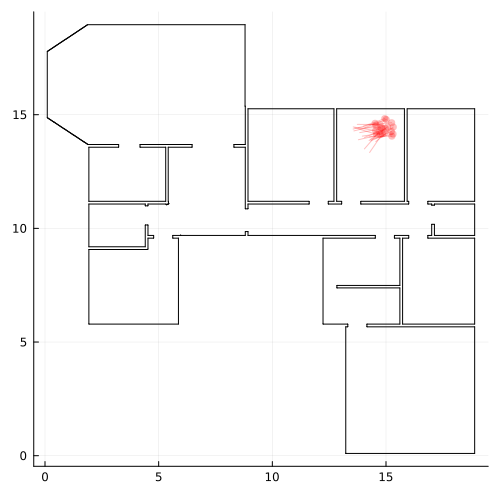

In [31]:
ps = [pose_prior_model() for t=1:20]
# -----------------
myplot = plot(size=(500,500), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
scatter!.(ps, alpha=0.25)
myplot

## Motion model

In [13]:
#nbx
"""
    p′ = motion_model(p, u, x_noise=0.25, hd_noise=22.5)

Sample a new pose `p′` given the previous pose `p`, 
some control data `u = (dx, dhd)`, and noise levels
`x_noise` and `hd_noise` (in degrees).
"""
@gen function motion_model(p, u, x_noise=0.25, hd_noise=22.5)
    dx, dhd = u
    x   ~ diagnormal(p.x  + dx , [x_noise, x_noise])
    hd  ~ normal(p.hd + dhd, hd_noise/360*2π)
    return p = Pose(x, hd)
end;

In [14]:
x_noise  = 0.25
hd_noise = 22.5;

motion_model(_ps[1], _us[1], x_noise, hd_noise)

Pose([14.61040966611021, 13.965306426936461], -2.4612560177862752)

## Sensor model and map

The sensor model is the only part that depends on the map.
Since in this notebook we are only concerned with localization, not mapping,
we assume we are given a map of the environment. In this notebook the map is a
bunch of line segments stored in `_segs`.

In [24]:
include("src/cuda_raycaster_line_map.jl");
display(@doc cast_v4!);

```
cast_v4!(X, P, Z; blockdims=(16,16))
```

Takes array of `n` stacked segments `X` and `m` stacked poses `P` and an observation array `Z` of shape `(n,m,k)` and fills it with depth measurements along angles `range(-π,π,k+1)[1:end-1]`.

Example:

```julia
n = 1000 # num segments
m =  500 # num poses

x = rand(n, 4)
p = zeros(m, 3)
z = ones(m, n, 360)

x_ = CuArray(x)
z_ = CuArray(z)
p_ = CuArray(p)

z′ = cast_v4!($x_,$p_,$z_; blockdims=(16,16))
```

Runtimes:

```julia
`cast_v4!` GPU vs CPU
x: (1000, 4), a: (360,), p: (1, 3)
data: (1000, 1), block: (16, 16), grid: (63, 1)
>>  218.122 μs (64 allocations: 3.50 KiB)

`cast_v4!` GPU vs CPU
x: (500, 4), a: (360,), p: (500, 3)
data: (500, 500), block: (16, 16), grid: (32, 32)
>>  2.516 ms (105 allocations: 6.16 KiB)
```


In [25]:
sensor_mix  = HeterogeneousMixture([diagnormal, anywhere])
sensor_dist = ProductDistribution(sensor_mix)

dropout = 0.1
n = 10
args = (fill([1-dropout,dropout], n), zeros(n,2), ones(n,2))
sensor_dist(args...)

10-element Vector{Vector{Float64}}:
 [0.27217012954821723, -1.4554800524722145]
 [1.0278505471242296, 2.170967003942632]
 [-0.5342845881026455, -1.6921162252771054]
 [-0.11733530191301367, 0.30738945660917116]
 [0.26761408086180233, 0.550779451568277]
 [0.2921462826156446, -1.03695955868492]
 [0.08120696919251552, 1.6260600827512774]
 [-0.08232376925482782, -1.2077880084394703]
 [0.051525972091142826, 1.057844924095854]
 [Inf, Inf]

In [26]:
_as[1]/π == - _as[end]/π, 
length(_as)

(false, 360)

In [27]:
_zs[1][1] == _zs[1][end]

false

In [193]:
segs_ = CuArray(stack(Vector.(_segs)))

function cast_GPU(ps; blockdims=(16,16))
    
    p_ = CuArray(stack(Vector.(ps)))
    
    n = size(segs_, 1)
    m = size(p_,1)
    
    z_ = Inf*CUDA.ones(m,n,360)
    

    datadims  = (n,m)
    z′ = cast_v4!(segs_,p_,z_; blockdims=(16,16))
    
    return Array(z′[:,1,:])
end

cast_GPU (generic function with 1 method)

In [85]:
@btime Inf.*CuArray{Float64}(undef, 500,500,360) samples=1 evals=1;
@btime Inf*CuArray{Float64}(undef, 500,500,360) samples=1 evals=1;

  150.271 μs (36 allocations: 2.14 KiB)
  145.915 μs (36 allocations: 2.14 KiB)


In [86]:
@btime CuArray(Inf*rand(500,360)) samples=1 evals=1;
@btime CuArray(Inf*rand(500,500,360)) samples=1 evals=1;
@btime Inf.*CUDA.ones(500,500,360) samples=1 evals=1;

  697.503 μs (8 allocations: 2.75 MiB)
  1.083 s (8 allocations: 1.34 GiB)
  165.765 μs (38 allocations: 2.17 KiB)


In [128]:
ps = [pose_prior_model() for t=1:500];

In [129]:
@btime cast_GPU($ps) samples=3 evals=3;

  3.106 ms (754 allocations: 72.50 KiB)


(500, 360)


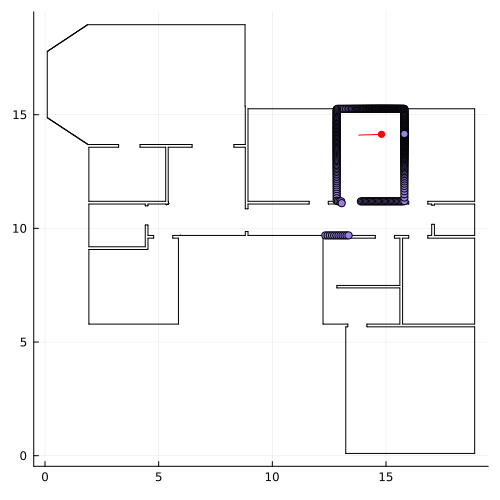

In [147]:
t  = 2
z_ = cast_GPU(ps)
println(size(z_))
z = Array(z_)
ys = [ps[t].x] .+ polar_inv(z[t,:], _as .+ ps[t].hd)
# ------
myplot = plot(size=(500,500), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
scatter!(ys)
scatter!(ps[t])

In [140]:
@btime circshift($z_, 2) samples=2 evals=2;
@btime circshift($z, 1) samples=2 evals=2;

  21.715 μs (75 allocations: 3.64 KiB)
  228.636 μs (2 allocations: 1.37 MiB)


In [194]:
@gen function sensor_model(p, std, dropout)
        z′ = cast_GPU([p])
        z′ = Array(z′[1,:])
        y′ = polar_inv(z′,_as)
        dropout = 0.1
        n = length(y′)
        args = (fill([1-dropout,dropout], n), y′, std*ones(n,2))
        y ~ sensor_dist(args...)
    
        return y,y′
end;

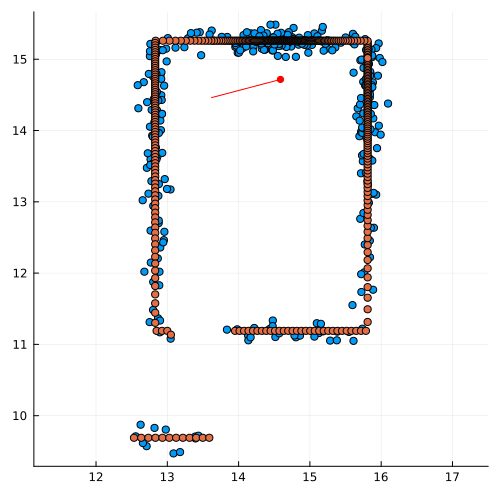

In [195]:
t=1
sensor_noise = 0.1
dropout = 0.1
y, y′ = sensor_model(ps[t], sensor_noise, dropout)

# ------
myplot = plot(size=(500,500), aspect_ratio=:equal, legend=nothing)
# plot!(_segs, c=:black)
scatter!(y.*ps[1])
scatter!(y′.*ps[1])
scatter!(ps[t])

In [200]:
args = (ps[t], sensor_noise, dropout)
@btime sensor_model(ps[t], sensor_noise, dropout) samples=1 evals=1;

  942.021 μs (4495 allocations: 274.17 KiB)


```julia
1.014 ms (4533 allocations: 270.06 KiB)
```

In [199]:
ch = choicemap(:y => polar_inv(_zs[t],_as))
@btime simulate(sensor_model, args) samples=1 evals=1;
@btime generate(sensor_model, args, ch) samples=1 evals=1;

  1.830 ms (11345 allocations: 560.30 KiB)
  1.413 ms (7521 allocations: 359.20 KiB)


```julia
>> 1.830 ms (11345 allocations: 560.30 KiB)
>> 1.413 ms (7521 allocations: 359.20 KiB)
```

## Sensor 2

In [226]:
mix = HomogeneousMixture(diagnormal, [1,1])
n = 360
@btime mix(ones(n)/n, rand(2,n), ones(2,n)) samples=1 evals=1;

  279.329 μs (26 allocations: 21.06 KiB)


In [237]:
sensor_i_dist = HeterogeneousMixture([mix, anywhere])

n = 5
args = ones(n)/n, rand(2,n), std*ones(2,n)
sensor_i_dist([0.8,0.2],args...)

2-element Vector{Float64}:
  0.08029076948319805
 -0.1570871203781559

In [264]:
@gen function sensor_mixture_model(p, std, dropout)
        z′ = cast_GPU([p])
        z′ = Array(z′[1,:])
        ys′ = polar_inv(z′,_as)
#         dropout = 0.1
        n = length(ys′)
#         args = (fill([1-dropout,dropout], n), y′, std*ones(n,2))

    ys = []
    for i=1:length(_as)
        args = ones(n)/n, hstack(ys′), std*ones(2,n)
        y = {:y => i} ~ mix(args...)
        

#         y = {:y => i} ~ sensor_i_dist([1-dropout,dropout],args...)
        push!(ys,y)
    end
       
    return ys,ys′
end;

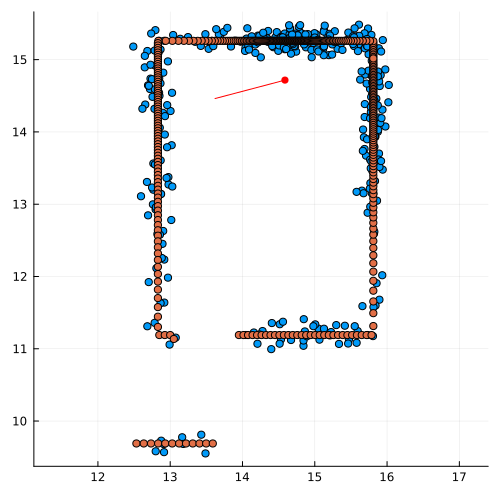

In [265]:
t=1
p = ps[t]
std = 0.1
dropout = .1
y,y′ = sensor_mixture_model(p, std, dropout)

# ------
myplot = plot(size=(500,500), aspect_ratio=:equal, legend=nothing)
# plot!(_segs, c=:black)
scatter!(y.*ps[1])
scatter!(y′.*ps[1])
scatter!(p)

In [266]:
args = (ps[t], sensor_noise, dropout)
@btime sensor_mixture_model(ps[t], sensor_noise, dropout) samples=1 evals=1;

  6.226 ms (10277 allocations: 9.48 MiB)


In [268]:
[(:y => i) => y for (i,y) in enumerate(polar_inv(_zs[t],_as))];

In [269]:
ch = choicemap([ (:y => i) => y for (i,y) in enumerate(polar_inv(_zs[t],_as))]...);

In [270]:
@btime simulate(sensor_mixture_model, args) samples=3 evals=3;
@btime generate(sensor_mixture_model, args, ch) samples=3 evals=3;

  242.393 ms (2477547 allocations: 89.85 MiB)
  242.432 ms (2472514 allocations: 88.63 MiB)


## Static Model

In [211]:
#nbx
@gen function slam_kernel(t, state, us, x_noise, hd_noise , s_noise, dropout)
    
        p,_ = state
        u = us[t]
    
        p = {:pose}   ~ motion_model(p, u, x_noise, hd_noise)
        y = {:sensor} ~ sensor_model(p, s_noise, dropout) # GPU accelerated
        
    return (p, y)
end

slam_chain = Gen.Unfold(slam_kernel)
Gen.@load_generated_functions

In [219]:
#nbx
"""
    [(p,z),...] = static_slam_model(T, segs_, a_, us, motion_noise, sensor_noise, dropout, inds)

Static SLAM model ...
"""
@gen (static) function static_slam_model(T, us, x_noise, hd_noise , s_noise, dropout)
    
    # Start the Markov chain; 
    # No motion, just the prior
    p = { :pose   } ~ pose_prior_model()
    y = { :sensor } ~ sensor_model(p, s_noise, dropout) # GPU accelerated
    
    # Unfold the MArkov chain
    chain ~ slam_chain(T, (p, nothing), us, x_noise, hd_noise , s_noise, dropout)
    
    return [(p,y);chain]
end

Gen.@load_generated_functions

In [220]:
T = 1

x_noise = 0.1
hd_noise = 5.
s_noise = 0.1
dropout = 0.1

args = (T, _us, x_noise, hd_noise , s_noise, dropout)
tr = simulate(static_slam_model, args);